In [ ]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
!nvidia-smi

Sat Nov  2 07:31:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip /content/drive/MyDrive/1_MIA_UNI/CICLO-II/DL/examen_final/archive.zip -d /content/drive/MyDrive/1_MIA_UNI/CICLO-II/DL/examen_final/dataset

In [ ]:
!ls "/content/drive/MyDrive/1_MIA_UNI/CICLO-II/DL/examen_final/dataset/Real Life Violence Dataset"

NonViolence  Violence


# Parameters

In [ ]:
img_height, img_width = 224, 224
batch_size = 16
epochs = 10
learning_rate = 0.001
sequence_length = 10  # Number of frames to consider in each sequence
dataset_path = '/content/drive/MyDrive/1_MIA_UNI/CICLO-II/DL/examen_final/dataset/Real Life Violence Dataset'

# Device configuration

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cuda


# transformations

In [ ]:
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# extract frames from a video

In [ ]:
def extract_frames(video_path, sequence_length, interval=10):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0
    while len(frames) < sequence_length:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % interval == 0:
            frame = cv2.resize(frame, (img_height, img_width))
            frames.append(frame)
        frame_count += 1
    cap.release()

    # Handle cases where there are fewer frames than sequence_length
    if len(frames) < sequence_length:
        while len(frames) < sequence_length:
            frames.append(frames[-1] if frames else cv2.resize(np.zeros((img_height, img_width, 3), dtype=np.uint8), (img_height, img_width)))
    else:
        frames = frames[:sequence_length]

    return frames

# Dataset

In [ ]:
class VideoDataset(Dataset):
    def __init__(self, video_files, labels, transform=None, sequence_length=10):
        self.video_files = video_files
        self.labels = labels
        self.transform = transform
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        frames = extract_frames(self.video_files[idx], self.sequence_length)
        if self.transform:
            frames = [self.transform(frame) for frame in frames]
        label = self.labels[idx]
        return torch.stack(frames), label

# Load dataset

In [ ]:
def load_dataset(dataset_path):
    video_files = []
    labels = []
    classes = os.listdir(dataset_path)
    for label, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        videos = os.listdir(class_path)
        for video_name in videos:
            video_path = os.path.join(class_path, video_name)
            video_files.append(video_path)
            labels.append(label)
    return video_files, labels

# Split

In [ ]:
video_files, labels = load_dataset(dataset_path)
train_videos, temp_videos, train_labels, temp_labels = train_test_split(video_files, labels, test_size=0.3, random_state=42)
val_videos, test_videos, val_labels, test_labels = train_test_split(temp_videos, temp_labels, test_size=0.5, random_state=42)

In [ ]:
train_dataset = VideoDataset(train_videos, train_labels, transform=data_transforms, sequence_length=sequence_length)
val_dataset = VideoDataset(val_videos, val_labels, transform=data_transforms, sequence_length=sequence_length)
test_dataset = VideoDataset(test_videos, test_labels, transform=data_transforms, sequence_length=sequence_length)

# DataLoader

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Model

In [ ]:
class MobileNetGRU(nn.Module):
    def __init__(self, hidden_dim, num_classes, num_layers=1):
        super(MobileNetGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Load pre-trained MobileNetV2
        self.mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        self.mobilenet.classifier = nn.Identity()  # Remove the last fully connected layer

        # GRU
        self.gru = nn.GRU(input_size=1280, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.size()

        # Reshape to (batch_size * seq_length, c, h, w) to feed each frame into MobileNet
        x = x.view(batch_size * seq_length, c, h, w)
        with torch.no_grad():
            x = self.mobilenet(x)

        # Reshape back to (batch_size, seq_length, 1280) to feed into GRU
        x = x.view(batch_size, seq_length, -1)

        # GRU
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        x, _ = self.gru(x, h0)

        # Classification
        x = self.fc(x[:, -1, :])  # Use the output of the last GRU cell

        return x

In [ ]:
hidden_dim = 512
num_classes = 2
model = MobileNetGRU(hidden_dim, num_classes).to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 138MB/s]


# loss function and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training

In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
        val_loss_history.append(val_epoch_loss)
        val_acc_history.append(val_epoch_acc.item())

        print(f'Epoch {epoch}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [ ]:
model, train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, criterion, optimizer, train_loader, val_loader, epochs)

Epoch 0/10, Loss: 0.3013, Acc: 0.8693, Val Loss: 0.1673, Val Acc: 0.9367
Epoch 1/10, Loss: 0.1815, Acc: 0.9279, Val Loss: 0.2399, Val Acc: 0.9067
Epoch 2/10, Loss: 0.1760, Acc: 0.9314, Val Loss: 0.2435, Val Acc: 0.8967
Epoch 3/10, Loss: 0.0980, Acc: 0.9614, Val Loss: 0.1254, Val Acc: 0.9433
Epoch 4/10, Loss: 0.1009, Acc: 0.9507, Val Loss: 0.1185, Val Acc: 0.9567
Epoch 5/10, Loss: 0.0677, Acc: 0.9736, Val Loss: 0.1225, Val Acc: 0.9400
Epoch 6/10, Loss: 0.0897, Acc: 0.9671, Val Loss: 0.1748, Val Acc: 0.9300
Epoch 7/10, Loss: 0.0372, Acc: 0.9843, Val Loss: 0.1214, Val Acc: 0.9467
Epoch 8/10, Loss: 0.0757, Acc: 0.9736, Val Loss: 0.1826, Val Acc: 0.9267
Epoch 9/10, Loss: 0.0422, Acc: 0.9857, Val Loss: 0.1088, Val Acc: 0.9600


# Evaluate

In [ ]:
model.eval()
test_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_acc = test_corrects.double() / len(test_loader.dataset)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9533


# Plotting

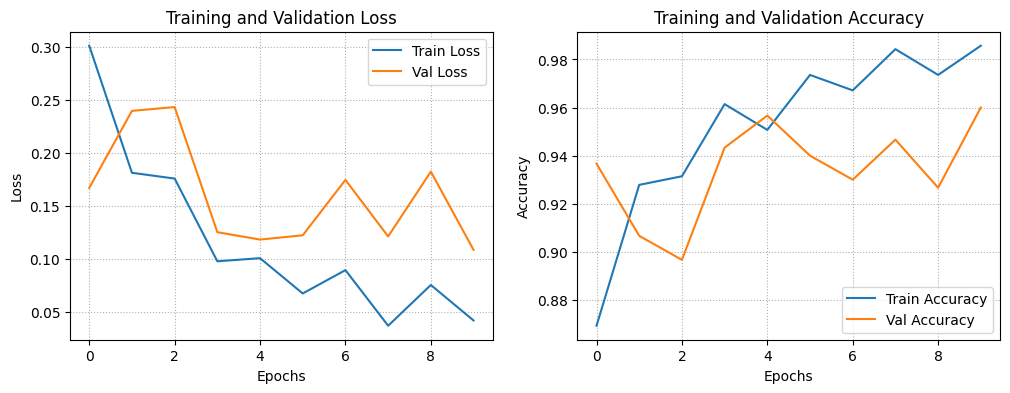

In [ ]:
epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, label='Train Loss')
plt.plot(epochs_range, val_loss_history, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(ls=":")
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_history, label='Train Accuracy')
plt.plot(epochs_range, val_acc_history, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(ls=":")
plt.title('Training and Validation Accuracy')

plt.show()

In [ ]:
# Save the entire model
torch.save(model, '/content/drive/MyDrive/1_MIA_UNI/CICLO-II/DL/examen_final/violence_detection_model.pth')

# Or save just the model state dict (recommended)
torch.save(model.state_dict(), '/content/drive/MyDrive/1_MIA_UNI/CICLO-II/DL/examen_final/violence_detection_model_state_dict.pth')

# Probando el modelo

In [ ]:
# Path to your single video file
video_file_path = '/content/drive/MyDrive/1_MIA_UNI/CICLO-II/DL/examen_final/dataset/Real Life Violence Dataset/NonViolence/NV_1.mp4'

In [ ]:
#import torch
#import cv2
import numpy as np

# Load the saved model
model = torch.load('/content/drive/MyDrive/1_MIA_UNI/CICLO-II/DL/examen_final/violence_detection_model.pth', map_location=device)
model.eval()

# Define the transformations
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Function to preprocess a single video
def preprocess_video(video_path):
    frames = extract_frames(video_path, sequence_length)
    frames = [data_transforms(frame) for frame in frames]
    return torch.stack(frames).unsqueeze(0).to(device)  # Add batch dimension

# Preprocess the video
video_tensor = preprocess_video(video_file_path)

# Make a prediction
with torch.no_grad():
    output = model(video_tensor)
    _, predicted = torch.max(output, 1)

# Print the prediction
print(f'Predicted class: {predicted.item()}') # 0 for NonViolence and 1 for Violence

<ipython-input-33-acd67c05c8a3>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/1_MIA_UNI/CICLO-II/DL/examen_final/violence_detec

Predicted class: 0


Predicted class: NonViolence


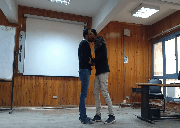

In [ ]:
from PIL import Image
#import cv2

# Ruta del video
video_path = video_file_path
cap = cv2.VideoCapture(video_path)

frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convertir a RGB para Pillow
    resized_frame = cv2.resize(frame, (180, 128))  # Redimensionar a 128x128
    frames.append(Image.fromarray(resized_frame))

cap.release()

# Guardar como GIF
gif_path = "output_video.gif"
frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=100, loop=0)

classes = ['NonViolence', 'Violence']
print(f'Predicted class: {classes[int(predicted.item())]}') # 0 for NonViolence and 1 for Violence
# Mostrar el GIF en el notebook
from IPython.display import Image
Image(filename=gif_path)
